In [5]:
!pip install xgboost --user

In [9]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from xgboost import XGBRegressor
import sklearn.metrics as metrics
import math
from scipy.stats import norm, skew
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [13]:
train = pd.read_csv("C:/Users/Public/Downloads/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("C:/Users/Public/Downloads/house-prices-advanced-regression-techniques/test.csv")

In [16]:
train.shape , test.shape 

((1460, 81), (1459, 80))

In [19]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [25]:
print(train['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


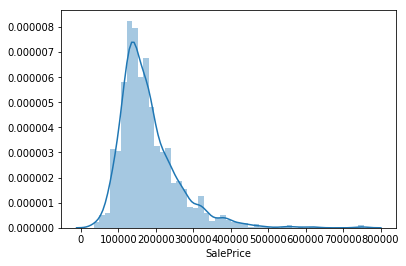

In [28]:
 sns.distplot(train['SalePrice'])

In [31]:
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


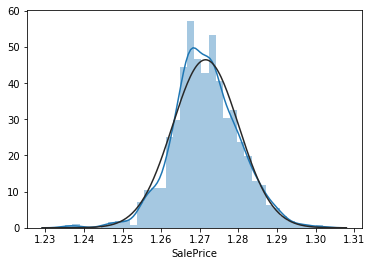

In [34]:
train['SalePrice'] = np.log1p(train['SalePrice'])
sns.distplot(train['SalePrice'], fit=norm);

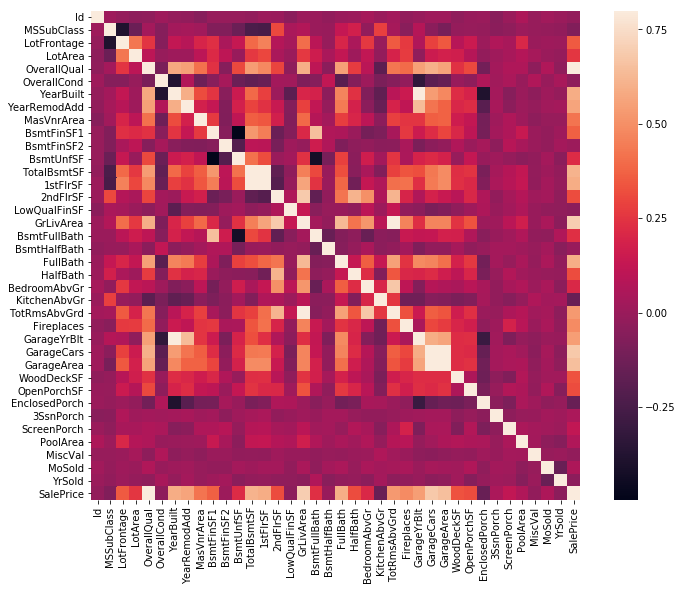

In [37]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

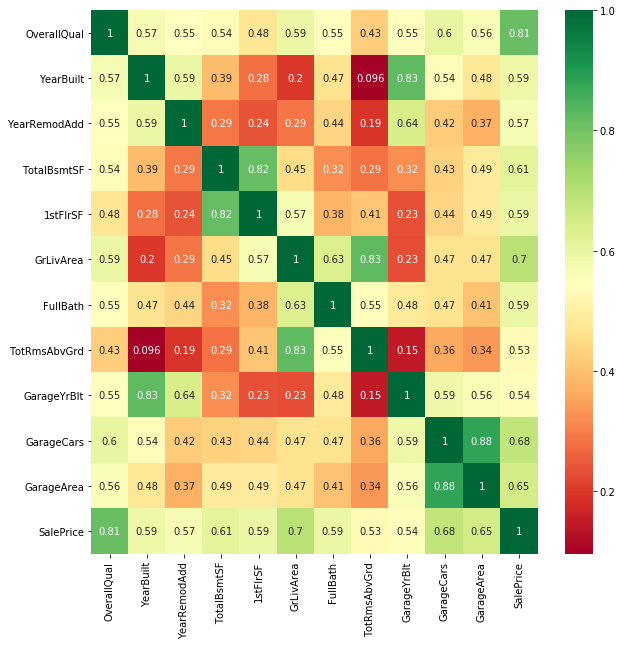

In [40]:
corr = train.corr()
highest_corr_features = corr.index[abs(corr["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[highest_corr_features].corr(),annot=True,cmap="RdYlGn")

In [43]:
corr["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.814276
GrLivArea        0.695805
GarageCars       0.679921
GarageArea       0.649144
TotalBsmtSF      0.608216
FullBath         0.593615
1stFlrSF         0.592491
YearBuilt        0.588223
YearRemodAdd     0.567048
GarageYrBlt      0.542977
TotRmsAbvGrd     0.531271
Fireplaces       0.488114
MasVnrArea       0.423820
BsmtFinSF1       0.368869
LotFrontage      0.353819
WoodDeckSF       0.332759
OpenPorchSF      0.318060
2ndFlrSF         0.317181
HalfBath         0.314768
LotArea          0.254799
BsmtFullBath     0.235507
BsmtUnfSF        0.220688
BedroomAbvGr     0.212503
ScreenPorch      0.121505
PoolArea         0.068063
MoSold           0.057424
3SsnPorch        0.055434
BsmtFinSF2       0.006648
BsmtHalfBath    -0.003184
Id              -0.017136
MiscVal         -0.019917
OverallCond     -0.030861
YrSold          -0.038074
LowQualFinSF    -0.038592
MSSubClass      -0.072020
KitchenAbvGr    -0.147098
EnclosedPorch   -0.150062
Name: SalePr

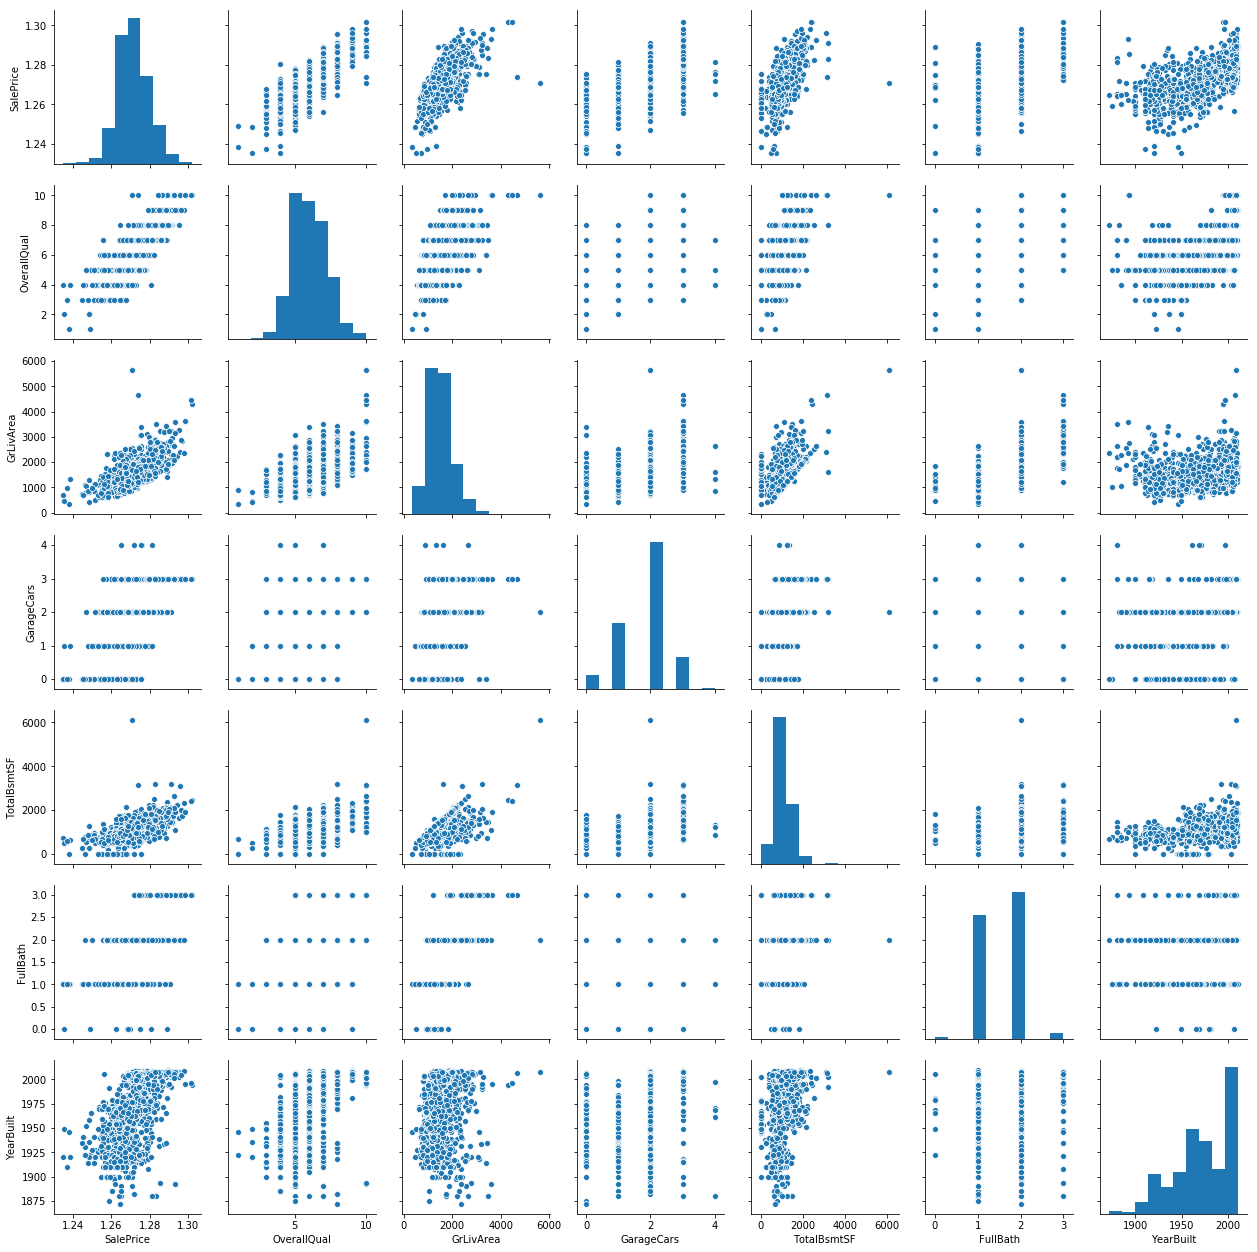

In [46]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols])

In [49]:
y_train = train['SalePrice']
test_id = test['Id']
all_data = pd.concat([train, test], axis=0, sort=False)
all_data = all_data.drop(['Id', 'SalePrice'], axis=1)

In [51]:
Total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum() / all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([Total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

Total   Percent
PoolQC         2909  0.996574
MiscFeature    2814  0.964029
Alley          2721  0.932169
Fence          2348  0.804385
FireplaceQu    1420  0.486468
LotFrontage     486  0.166495
GarageCond      159  0.054471
GarageQual      159  0.054471
GarageYrBlt     159  0.054471
GarageFinish    159  0.054471
GarageType      157  0.053786
BsmtCond         82  0.028092
BsmtExposure     82  0.028092
BsmtQual         81  0.027749
BsmtFinType2     80  0.027407
BsmtFinType1     79  0.027064
MasVnrType       24  0.008222
MasVnrArea       23  0.007879
MSZoning          4  0.001370
BsmtHalfBath      2  0.000685
Utilities         2  0.000685
Functional        2  0.000685
BsmtFullBath      2  0.000685
BsmtFinSF2        1  0.000343
BsmtFinSF1        1  0.000343

In [53]:
all_data.drop((missing_data[missing_data['Total'] > 5]).index, axis=1, inplace=True)
print(all_data.isnull().sum().max())

KeyError: "['PoolQC' 'MiscFeature' 'Alley' 'Fence' 'FireplaceQu' 'LotFrontage'\n 'GarageCond' 'GarageQual' 'GarageYrBlt' 'GarageFinish' 'GarageType'\n 'BsmtCond' 'BsmtExposure' 'BsmtQual' 'BsmtFinType2' 'BsmtFinType1'\n 'MasVnrType' 'MasVnrArea'] not found in axis"

In [ ]:
total = all_data.isnull().sum().sort_values(ascending=False)
total.head(19)

In [54]:
numeric_missed = ['BsmtFinSF1',
                  'BsmtFinSF2',
                  'BsmtUnfSF',
                  'TotalBsmtSF',
                  'BsmtFullBath',
                  'BsmtHalfBath',
                  'GarageArea',
                  'GarageCars']

for feature in numeric_missed:
    all_data[feature] = all_data[feature].fillna(0)

In [55]:
categorical_missed = ['Exterior1st',
                  'Exterior2nd',
                  'SaleType',
                  'MSZoning',
                   'Electrical',
                     'KitchenQual']

for feature in categorical_missed:
    all_data[feature] = all_data[feature].fillna(all_data[feature].mode()[0])

In [56]:
all_data['Functional'] = all_data['Functional'].fillna('Typ')

In [57]:
all_data.drop(['Utilities'], axis=1, inplace=True)

In [58]:
all_data.isnull().sum().max()

0

In [59]:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_feats[abs(skewed_feats) > 0.5]
high_skew

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
OpenPorchSF       2.535114
WoodDeckSF        1.842433
1stFlrSF          1.469604
BsmtFinSF1        1.425230
MSSubClass        1.375457
GrLivArea         1.269358
TotalBsmtSF       1.156894
BsmtUnfSF         0.919339
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.624832
OverallCond       0.570312
YearBuilt        -0.599806
dtype: float64

In [60]:
for feature in high_skew.index:
    all_data[feature] = np.log1p(all_data[feature])

In [61]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [62]:
all_data = pd.get_dummies(all_data)
all_data.head()

MSSubClass   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0    4.110874  9.042040            7     1.791759   7.602900          2003   
1    3.044522  9.169623            6     2.197225   7.589336          1976   
2    4.110874  9.328212            7     1.791759   7.601902          2002   
3    4.262680  9.164401            7     1.791759   7.557995          1970   
4    4.110874  9.565284            8     1.791759   7.601402          2000   

   BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF          ...            \
0    6.561031         0.0   5.017280     6.753438          ...             
1    6.886532         0.0   5.652489     7.141245          ...             
2    6.188264         0.0   6.075346     6.825460          ...             
3    5.379897         0.0   6.293419     6.629363          ...             
4    6.486161         0.0   6.196444     7.044033          ...             

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0             0             0            1   
1               0             0             0            1   
2               0             0             0            1   
3               0             0             0            1   
4               0             0             0            1   

   SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
0                      0                      0                     0   
1                      0                      0                     0   
2                      0                      0                     0   
3                      1                      0                     0   
4                      0                      0                     0   

   SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                     0                     1                      0  
1                     0                     1                      0  
2                     0                     1                      0  
3                     0                     0                      0  
4                     0                     1                      0  

[5 rows x 219 columns]

In [63]:
x_train =all_data[:len(y_train)]
x_test = all_data[len(y_train):]

In [64]:
x_test.shape , x_train.shape

((1459, 219), (1460, 219))

In [65]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

scorer = make_scorer(mean_squared_error,greater_is_better = False)
def rmse_CV_train(model):
    kf = KFold(5,shuffle=True,random_state=42).get_n_splits(x_train.values)
    rmse = np.sqrt(-cross_val_score(model, x_train, y_train,scoring ="neg_mean_squared_error",cv=kf))
    return (rmse)
def rmse_CV_test(model):
    kf = KFold(5,shuffle=True,random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, x_test, y_test,scoring ="neg_mean_squared_error",cv=kf))
    return (rmse)

  Using cached https://files.pythonhosted.org/packages/3d/1b/83e5dc0021d12884e9998999945e156cf3628a79dacecaed2ede9f3107cb/xgboost-1.3.3-py3-none-win_amd64.whl


In [4]:
xgboostimport xgboost as XGB

the_model = XGB.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, random_state =7, nthread = -1)
the_model.fit(x_train, y_train)

SyntaxError: invalid syntax (<ipython-input-4-21802433f95e>, line 1)